In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [3]:
Batch_Size = 32 # 32 images in 1 batch
Channels = 3  # RGB
Image_Size = 256  # 256x256
Epoches = 50  # for training purpose


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "IMAGES",
    batch_size=Batch_Size,
    shuffle=True,
    image_size=(Image_Size, Image_Size)


)


Found 4217 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
for class_name in class_names:
    print(class_name)


cataract
diabetic_retinopathy
glaucoma
normal


# IMAGE VISUALIZATION

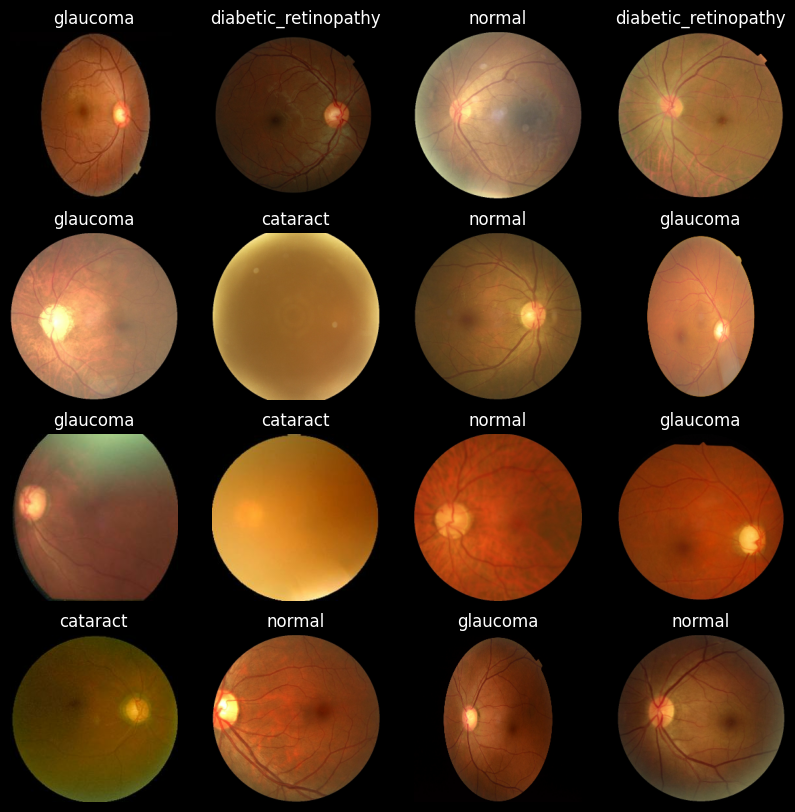

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [8]:

len(dataset)  # number of epoches


132

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=2000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [12]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
# sum should be equal to epoche size or number of batches


105
13
14


# Cache, Shuffle, and Prefetch the Dataset


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1./255),
])


# DATA AGUMENTATION
#### Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),  # Add random contrast adjustment
  layers.experimental.preprocessing.RandomZoom(0.2),      # Add random zoom
])


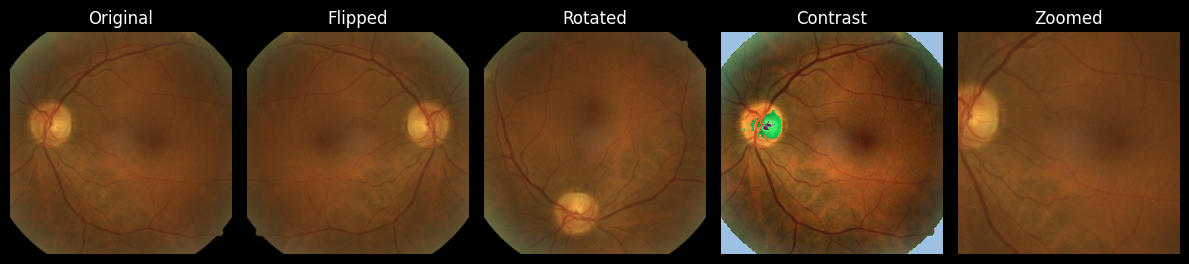

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Select a single image from the dataset
image_index = 1
image = next(iter(train_ds.unbatch().skip(image_index).take(1)))[0]

# Apply different augmentations to the image
flipped_image = tf.image.flip_left_right(image)
rotated_image = tf.image.rot90(image)
contrast_image = tf.image.adjust_contrast(image, 2)  # Increase contrast
zoomed_image = tf.image.central_crop(image, 0.7)     # Zoom into the image

# Plot the original and augmented images
plt.figure(figsize=(12, 4))
titles = ["Original", "Flipped", "Rotated", "Contrast", "Zoomed"]
images = [image, flipped_image, rotated_image, contrast_image, zoomed_image]

for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.title(titles[i], fontsize=12)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.tight_layout()
plt.show()


In [19]:
input_shape = (Batch_Size, Image_Size ,Image_Size, Channels)
n_classes = 4

model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
105/105 [==============================] - 199s 2s/step - loss: 1.3392 - accuracy: 0.3555 - val_loss: 1.1962 - val_accuracy: 0.4567
Epoch 2/50
105/105 [==============================] - 207s 2s/step - loss: 1.1793 - accuracy: 0.4852 - val_loss: 1.0911 - val_accuracy: 0.5481
Epoch 3/50
105/105 [==============================] - 201s 2s/step - loss: 1.0759 - accuracy: 0.5395 - val_loss: 1.0053 - val_accuracy: 0.5433
Epoch 4/50
105/105 [==============================] - 235s 2s/step - loss: 1.0127 - accuracy: 0.5684 - val_loss: 0.9747 - val_accuracy: 0.5553
Epoch 5/50
105/105 [==============================] - 232s 2s/step - loss: 0.9430 - accuracy: 0.6024 - val_loss: 0.9128 - val_accuracy: 0.5817
Epoch 6/50
105/105 [==============================] - 215s 2s/step - loss: 0.8993 - accuracy: 0.6144 - val_loss: 0.9000 - val_accuracy: 0.5889
Epoch 7/50
105/105 [==============================] - 201s 2s/step - loss: 0.8772 - accuracy: 0.6320 - val_loss: 0.8484 - val_accuracy: 0.6034

first image to predict
actual label: glaucoma
1/1 [==============================] - 0s 425ms/step
predicted label: glaucoma


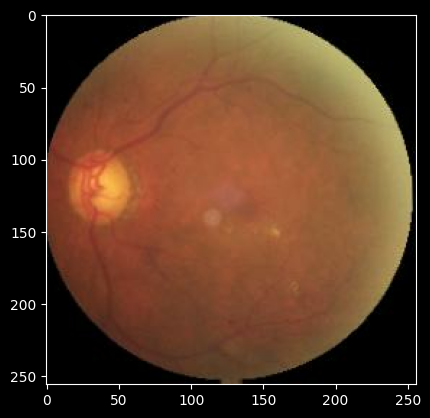

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


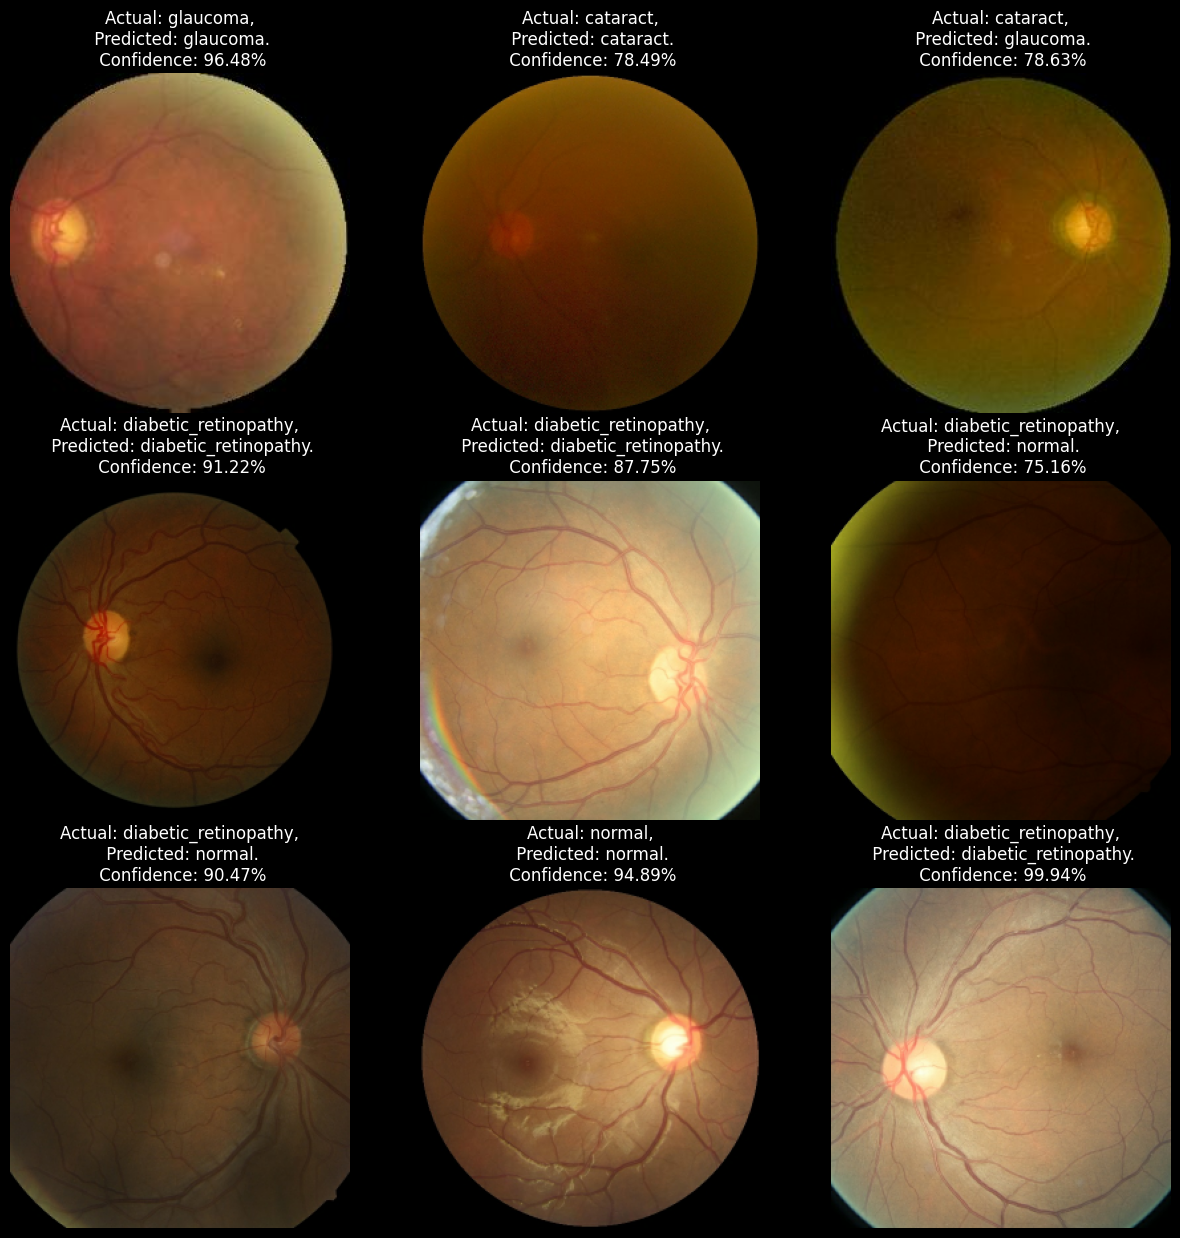

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")